# TCGA-CRC Preprocess

In [7]:
import os
import functools
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import importlib

import openslide
from openslide import deepzoom
import tifffile
import nibabel

%matplotlib inline

# import utils
# import staintools
datadir = "H:/"

# Data cleaning

In [5]:
df = pd.read_csv(datadir + 'TCGA/tcga_crc_files.csv')
print(df.shape)
df.head(1)

(625, 9)


,project,wsi,msi_status,uuid,patient,filename,filepath,size,md5
0,TCGA-COAD,TCGA-AA-A00R-01Z-00-DX1,MSI-H,397337b9-9f03-4edc-935d-a0d4e15bf006,TCGA-AA-A00R,TCGA-AA-A00R-01Z-00-DX1.7520405C-E7DD-46A4-BB6...,TCGA/wsi/TCGA-AA-A00R-01Z-00-DX1.7520405C-E7DD...,431269154,5df8ffb72c5319ea6afd293f658ae4ee


### undownloaded files

In [26]:
df['download'] = df['filepath'].map(lambda x: os.path.isfile(datadir + x))

print((~df['download']).sum(), 'not downloaded')
df.head(1)

5 not downloaded


,project,wsi,msi_status,uuid,patient,filename,filepath,size,md5,download
0,TCGA-COAD,TCGA-AA-A00R-01Z-00-DX1,MSI-H,397337b9-9f03-4edc-935d-a0d4e15bf006,TCGA-AA-A00R,TCGA-AA-A00R-01Z-00-DX1.7520405C-E7DD-46A4-BB6...,TCGA/wsi/TCGA-AA-A00R-01Z-00-DX1.7520405C-E7DD...,431269154,5df8ffb72c5319ea6afd293f658ae4ee,True


### magnification

In [49]:
def get_resolution(file):
    if not os.path.isfile(file):
        return np.nan
    
    img = openslide.OpenSlide(file)
    if 'aperio.MPP' in img.properties:
        return float(img.properties['aperio.MPP'])
    else:
        return np.nan

CPU times: user 42.1 ms, sys: 0 ns, total: 42.1 ms
Wall time: 35.6 ms


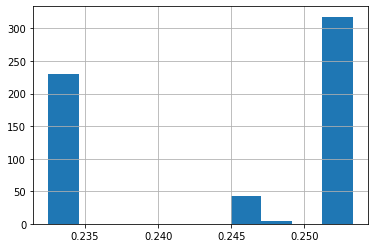

In [54]:
%%time

# df['resolution'] = df['filepath'].map(lambda x: get_resolution(datadir + x))
df['resolution'].hist()

In [66]:
idx1 = ~df['download']
idx2 = df['resolution'].notnull()

df['magnification'] = 20
df.loc[idx1, 'magnification'] = 0
df.loc[idx2, 'magnification'] = 40

# df.to_csv(datadir + 'tcga/tcga_crc_summary.csv', index=False)

print(df['magnification'].value_counts())
df.head(1)

40    595
20     25
0       5
Name: magnification, dtype: int64


,project,wsi,msi_status,uuid,patient,filename,filepath,size,md5,download,resolution,magnification
0,TCGA-COAD,TCGA-AA-A00R-01Z-00-DX1,MSI-H,397337b9-9f03-4edc-935d-a0d4e15bf006,TCGA-AA-A00R,TCGA-AA-A00R-01Z-00-DX1.7520405C-E7DD-46A4-BB6...,TCGA/wsi/TCGA-AA-A00R-01Z-00-DX1.7520405C-E7DD...,431269154,5df8ffb72c5319ea6afd293f658ae4ee,True,0.2325,40


# Generate x2.5 WSI

In [13]:
df = pd.read_csv(datadir + 'tcga/tcga_crc_summary.csv')
print(df.shape)
df.head(1)

(625, 12)


,project,wsi,msi_status,uuid,patient,filename,filepath,size,md5,download,resolution,magnification
0,TCGA-COAD,TCGA-AA-A00R-01Z-00-DX1,MSI-H,397337b9-9f03-4edc-935d-a0d4e15bf006,TCGA-AA-A00R,TCGA-AA-A00R-01Z-00-DX1.7520405C-E7DD-46A4-BB6...,TCGA/wsi/TCGA-AA-A00R-01Z-00-DX1.7520405C-E7DD...,431269154,5df8ffb72c5319ea6afd293f658ae4ee,True,0.2325,40


In [29]:
# %%time

# for idx, row in df.iterrows():
#     if not row['download']:
#         continue
        
#     file = datadir + row['filepath']
#     mag = row['magnification']

#     img = openslide.OpenSlide(file)

#     dzg = deepzoom.DeepZoomGenerator(img)
#     level_idx = dzg.level_count - 1 - int(np.log2(mag // 2.5))
#     wsi_shape = dzg.level_dimensions[level_idx]

#     dzg = deepzoom.DeepZoomGenerator(img, tile_size=max(wsi_shape))
#     wsi_2dot5 = dzg.get_tile(level_idx, (0, 0))

#     tifffile.imsave(
#         datadir + 'tcga/wsi_2.5/' + row['filename'].replace('.svs', '.tif'),
#         np.array(wsi_2dot5), 
#         compress=9)
    
#     if (idx + 1) % 50 == 0:
#         print(idx + 1)

50
100
150
200
250
300
350
400
450
500
550
600
Wall time: 7h 19min 25s


# Remove grey background and color normalization

In [20]:
a = np.array(wsi_2dot5)
b = a.reshape(-1, 3)
c = np.unique(b, axis=0, return_counts=True)
c

(array([[  9,   8,  12],
        [ 14,  11,  22],
        [ 24,  10,  36],
        ...,
        [255, 255, 253],
        [255, 255, 254],
        [255, 255, 255]], dtype=uint8),
 array([      1,       1,       1, ...,     354,    5249, 3830633],
       dtype=int64))

# Generate tumor mask

In [8]:
nii_dir = datadir + 'TCGA/mask_nii/'
show_dir = datadir + 'TCGA/mask_show/'
mask_dir = datadir + 'TCGA/mask/'
os.makedirs(show_dir, exist_ok=True)
os.makedirs(mask_dir, exist_ok=True)

for fname in os.listdir(nii_dir):
    nii = nibabel.load(nii_dir + fname)
    
    mask = nii.get_fdata()[:, :, 0].astype(np.uint8).transpose()
    fpath_mask = mask_dir + fname.split('.')[0] + '.tif'
    tifffile.imsave(fpath_mask, mask, compress=9)
    
    show = mask * 255
    fpath_show = show_dir + fname.split('.')[0] + '.tif'
    tifffile.imsave(fpath_show, show, compress=9)